## Rydberg Rabi Flopping Simulation

In [1]:
# not all of these import necessary; many are for debugging
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from sympy import MatrixSymbol,MatMul,Matrix,symbols,Function,pi
from sympy.utilities.lambdify import lambdify
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from sympy.physics.quantum import TensorProduct as TP
from sympy.physics.quantum.commutator import Commutator as comm
import sympy as sp
from numpy import zeros, conj
import time
import os, sys

In [8]:
sys.path.append(os.path.join('..','')) # atomsim in parent dir

# # local imports
from physconsts import *
from rbconsts import *
from atomsim import AtomSim, comm

basis states: (might need more to properly handle decay)  
$|{0}\rangle = |5s_{1/2},F=3,m_F=0\rangle$  
$|{1}\rangle = |5s_{1/2},F=2,m_F=0\rangle$  
$|{e}\rangle = |5p_{3/2},F=2,m_F=1\rangle$  
$|{r}\rangle = |84d_{5/2},J=3/2,m_J=3/3\rangle$

In [31]:
# build the hamiltonian
w = 10
O1max = 2*pi
O2max = O1max
O2 = O2max # constant field intensity
O1 = O1max # constant field intensity
D1 = 10*O1max 
D2 = -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0

H = Matrix([[0,  0,    0,    0],
            [0,  0,   O1/2,  0],
            [0, O1/2,  -D1, O2/2],
            [0,   0,   O2/2, -(D1+D2)]])

# H = TP(H,H) # uncomment for 2-atom system <-- this didn't work... maybe can't simply TP the full Hamiltonian

In [32]:
O = abs(O1max*O2max/(2*D1))/(2*pi)
print(f"Two-photon Rabi frequency = 2*pi*{O:.2f} [arb]")

## set up the simulation 
N = H.shape[0]
rho0 = zeros(int(N*(N + 1)/2), complex)
rho0[4] = 1 + 0j # population starts in ground state
sim = AtomSim(rho0, t_exp=10, hamiltonian=H, _hbar=1)

Two-photon Rabi frequency = 2*pi*0.05 [arb]


In [33]:
t0 = time.time()
rho, t = sim.runsim(t_exp=10)
print(f"Run time: {time.time() - t0}")

Run time: 0.36901354789733887


Text(0.5, 1.0, 'Three Level Rabi Flopping')

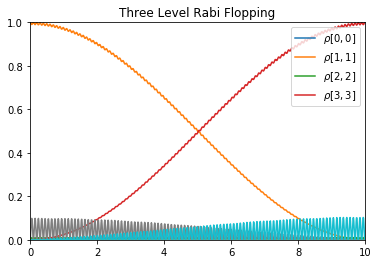

In [34]:
kwargs = {'figsize':(6,4)}
fig, axes = sim.plots(show=['populations'], coherences=True,
                      kwargs=kwargs)
ax = axes[0]
ax.set_ylim((0,1))
ax.set_title('Three Level Rabi Flopping')

### debugging